In [2]:
# NOTA: Este notebook está escrito asumiendo ejecución en un entorno estándar de Jupyter
# con scikit-learn, pandas y matplotlib instalados.

import pandas as pd
import numpy as np

# Para cargar el dataset Iris directamente de scikit-learn
from sklearn.datasets import load_iris

# Para separar datos en train/test
from sklearn.model_selection import train_test_split

# Para crear y trabajar con Pipelines
from sklearn.pipeline import Pipeline

# Transformadores y modelo de ejemplo
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

# Para la evaluación del modelo
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Carga del dataset

El dataset Iris contiene 150 observaciones de flores de tres especies diferentes de Iris: Iris setosa, Iris versicolor, e Iris virginica. Cada observación tiene 4 características numéricas:

- sepal length (cm)

- sepal width (cm)

- petal length (cm)

- petal width (cm)

Y una etiqueta de clase que indica la especie.

In [3]:
# Cargamos el dataset Iris
iris_data = load_iris()

# iris_data es un Bunch que contiene:
# - iris_data.data con la matriz de características
# - iris_data.target con los valores de la clase (0, 1 o 2)
# - iris_data.feature_names con los nombres de las características
# - iris_data.target_names con los nombres de las clases

X = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
y = pd.Series(iris_data.target, name='class')

# Revisamos las primeras filas
X.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


# Exploración inicial de los datos

Aunque es un dataset muy conocido y limpio, siempre conviene revisarlo para tener un panorama claro:



In [4]:
# Dimensiones del dataset
print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

# Descripción estadística
display(X.describe())

# Revisamos la distribución de la variable objetivo
print("Distribución de la clase (y):")
print(y.value_counts())


Dimensiones de X: (150, 4)
Dimensiones de y: (150,)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Distribución de la clase (y):
class
0    50
1    50
2    50
Name: count, dtype: int64


Observamos:

- Tenemos 150 muestras y 4 variables (todas numéricas).

- El dataset está muy balanceado entre las tres clases: 50 muestras de cada especie.

- En cuanto a transformaciones, podemos querer escalar los datos, generar alguna característica derivada, o incluso aplicar técnicas como PCA (Análisis de Componentes Principales).

¿Qué transformaciones podríamos aplicar?

- Escalado: Dado que las variables tienen distintas magnitudes (por ejemplo, la longitud de pétalo suele ser mayor que la anchura de pétalo), un escalado puede ayudar a algunos modelos a converger mejor.

- Creación de nuevas características: Podríamos, por ejemplo, crear una característica que represente la razón o proporción entre la longitud y anchura de sépalo (o pétalo).

# Introducción al concepto de Pipelines

Un Pipeline en scikit-learn nos permite encadenar varios pasos de preprocesamiento/transformación y, finalmente, un estimador (modelo). De esta forma, podemos:

- Evitar fugas de información (pues cada paso en el pipeline se ajusta únicamente con datos de entrenamiento).

- Tener un único objeto que encapsula la secuencia de transformaciones + el modelo.

- Hacer más ordenado y reproducible el flujo de preprocesamiento.

La idea es algo como:

[ (paso1, transformador1), (paso2, transformador2), ..., (último_paso, modelo) ]

# Introducción al uso de clases (para transformadores personalizados)

En scikit-learn, podemos crear un transformador personalizado definiendo una clase que implemente los métodos fit, transform y (opcionalmente) fit_transform. Además, se suele basar en la clase BaseEstimator y TransformerMixin de sklearn, que facilitan la compatibilidad con el ecosistema de scikit-learn.

Por ejemplo, creemos una clase que genere una nueva característica: la proporción entre la longitud y la anchura del sépalo (columna sepal length (cm) / sepal width (cm)). Esta clase:

- Durante fit, no necesita aprender nada; solo es un paso formal.

- Durante transform, añadirá la columna sepal_ratio y devolverá el nuevo conjunto de datos.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class SepalRatioAdder(BaseEstimator, TransformerMixin):
    """
    Transformador personalizado que añade la columna 'sepal_ratio'
    (sepal_length / sepal_width).
    """
    
    def __init__(self):
        # En este ejemplo, no necesitamos inicializar nada en particular
        pass
    
    def fit(self, X, y=None):
        # Aquí no hacemos nada, pues no hay parámetros que aprender
        return self
    
    def transform(self, X, y=None):
        # Asegurémonos de que X sea DataFrame para mayor facilidad
        X_ = pd.DataFrame(X, columns=iris_data.feature_names, copy=True)
        
        X_["sepal_ratio"] = X_["sepal length (cm)"] / X_["sepal width (cm)"]
        
        return X_


## ¿Por qué un transformador personalizado?

Podemos encapsular cualquier lógica de preprocesamiento que no venga de serie con scikit-learn.
El uso de clases hace que nuestro código sea más modular y mantenible.

# Aplicando todo en un Pipeline

Vamos a construir un Pipeline con estos pasos:

1. Añadir la nueva característica sepal_ratio (nuestra clase SepalRatioAdder).

2. Escalar los datos (por ejemplo con StandardScaler).

3. Entrenar un modelo de clasificación (por ejemplo LogisticRegression).

Finalmente, evaluaremos la exactitud (accuracy) del modelo en un conjunto de prueba.

In [7]:
# Dividimos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Definimos nuestro pipeline
pipeline = Pipeline([
    ("sepal_ratio_adder", SepalRatioAdder()),  # Paso 1: añadir columna
    ("scaler", StandardScaler()),              # Paso 2: escalar datos
    ("clf", LogisticRegression())              # Paso 3: modelo
])

# Ajustamos el pipeline a los datos de entrenamiento
pipeline.fit(X_train, y_train)

# Hacemos predicciones en los datos de prueba
y_pred = pipeline.predict(X_test)

# Calculamos la exactitud
acc = accuracy_score(y_test, y_pred)
print(f"Exactitud en el conjunto de prueba: {acc:.2f}")


Exactitud en el conjunto de prueba: 0.93


In [ ]:
# Podemos inspeccionar los pasos del pipeline, cada transformador y el modelo final:

print("Pasos del pipeline:")
for name, step in pipeline.named_steps.items():
    print(f"- {name}: {step}")


Nota: Si quisiéramos ver, por ejemplo, cómo quedaron los datos transformados después de cada paso, podríamos usar pipeline.named_steps["sepal_ratio_adder"].transform(X_train) (o análogo para el escalador). Sin embargo, hay que recordar que este pipeline se ajusta pensando en el flujo completo de entrenamiento.

# Visualización rápida de alguna característica

Podemos hacer una visualización rápida, por ejemplo, del histograma de la nueva característica sepal_ratio tras crearse. Para ello, transformamos los datos de entrenamiento con nuestro primer paso y mostramos un histograma:

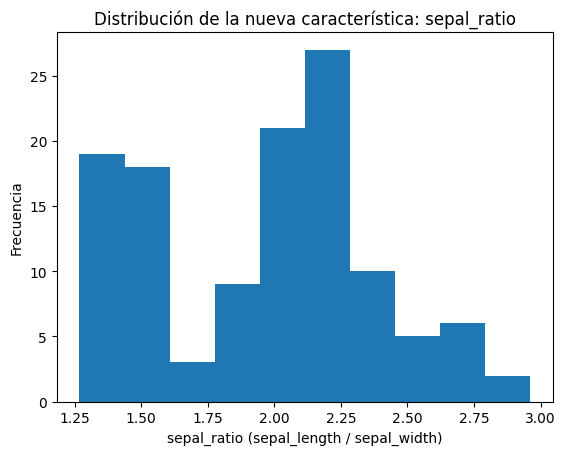

In [8]:
# Transformamos los datos de entrenamiento con nuestro custom transformer
X_train_sepal_ratio = pipeline.named_steps["sepal_ratio_adder"].transform(X_train)

plt.figure()
plt.hist(X_train_sepal_ratio["sepal_ratio"], bins=10)
plt.title("Distribución de la nueva característica: sepal_ratio")
plt.xlabel("sepal_ratio (sepal_length / sepal_width)")
plt.ylabel("Frecuencia")
plt.show()
